In [44]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

In [45]:
#Carga del dataset tras limpieza y transformación
df = pd.read_csv('Proyecto-DA-Promo-64-Modulo-3-Team-2/data/processed/hr_processed.csv')

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          1470 non-null   int64  
 1   age                         1470 non-null   int64  
 2   attrition                   1470 non-null   object 
 3   business_travel             1470 non-null   object 
 4   daily_rate                  1470 non-null   float64
 5   department                  1470 non-null   object 
 6   distance_from_home          1470 non-null   int64  
 7   education                   1470 non-null   object 
 8   education_field             1470 non-null   object 
 9   environment_satisfaction    1470 non-null   object 
 10  gender                      1470 non-null   object 
 11  hourly_rate                 1470 non-null   float64
 12  job_involvement             1470 non-null   object 
 13  job_level                   1470 

---
### **DISCRETIZACIÓN DE VARIABLES**

La discretización de las variables numéricas se realiza para transformar datos continuos en categorías lógicas que permitan:

1.  **Optimizar la Visualización:** Facilita la creación de matrices de calor y gráficos comparativos, evitando ejes saturados con valores infinitos.
2.  **Identificar Patrones de Segmentación:** Permite detectar "umbrales de riesgo" específicos (ej. grupos de edad o rangos salariales) que son invisibles en un análisis de promedio general.
3.  **Facilitar la Acción Empresarial:** Traduce los datos en segmentos accionables para el departamento de Recursos Humanos

In [47]:
# age
df["age_range"] = pd.cut(df["age"], bins=[0, 29, 35, 45, 100], labels=["<30 y.o.", "30-35", "36-45", "46+"])
# daily_rate
df["daily_rate_level"] = pd.qcut(df["daily_rate"], q=4, labels=["Low", "Mid-Low", "Mid-High", "High"])
# distance_from_home
df["distance_cat"] = pd.cut(df["distance_from_home"], bins=[0, 2, 5, 8, 16, 100], labels=["Very Close", "Close", "Moderate", "Far", "Very Far"])
# hourly_rate
df["hourly_rate_level"] = pd.qcut(df["hourly_rate"], q=4, labels=["Low", "Mid-Low", "Mid-High", "High"])
# monthly_income
df["mon_income_range"] = pd.qcut(df["monthly_income"], q=4, labels=["Low", "Mid-Low", "Mid-High", "High"])
# num_companies_worked
df["num_co_segment"] = pd.cut(df["num_companies_worked"], bins=[-1, 2, 5, 100], labels=["0-2 Co.", "3-5 Co.", "6+ Co."])
# over_time (mantener original)
# percent_salary_hike
df["salary_hike_level"] = pd.cut(df["percent_salary_hike"], bins=[0, 12, 15, 20, 100], labels=["Low", "Mid-Low", "Mid-High", "High"])
# total_working_years
df["experience_range"] = pd.cut(df["total_working_years"], bins=[0, 5, 10, 20, 100], labels=["<5 Yrs", "5-10 Yrs", "11-20 Yrs", "21+ Yrs"])
# training_times_last_year
df["training_frequency"] = pd.cut(df["training_times_last_year"], bins=[-1, 2, 4, 100], labels=["0-2 sessions", "3-4 sessions", "5+ sessions"])
# years_at_company
df["seniority_range"] = pd.cut(df["years_at_company"], bins=[-1, 2, 7, 15, 100], labels=["<3 Yrs", "3-7 Yrs", "8-15 Yrs", "16+ Yrs"])
# years_in_current_role
df["role_seniority_range"] = pd.cut(df["years_in_current_role"], bins=[-1, 2, 4, 8, 100], labels=["<2 Yrs", "2-4 Yrs", "5-8 Yrs", "9+ Yrs"])
# years_since_last_promotion
df["promo_gap_range"] = pd.cut(df["years_since_last_promotion"], bins=[-1, 0, 2, 6, 100], labels=["<1 Yr", "1-2 Yrs", "3-6 Yrs", "7+ Yrs"])
# years_with_curr_manager
df["manager_tenure_range"] = pd.cut(df["years_with_curr_manager"], bins=[-1, 2, 4, 8, 100], labels=["<2 Yrs", "2-4 Yrs", "5-8 Yrs", "9+ Yrs"])

In [48]:
ordenes_logicos = {
    'age_range': ["<30 y.o.", "30-35", "36-45", "46+"],
    'business_travel': ['Non', 'Rarely', 'Frequently'],
    'daily_rate_level': ["Low", "Mid-Low", "Mid-High", "High"],
    'department': ["Sales", "Research & Development", "Human Resources"],
    'distance_cat': ["Very Close", "Close", "Moderate", "Far", "Very Far"], 
    'education': ['No Formal Education', 'Basic Education', 'Associate Degree', 'Bachelor Degree', 'Postgraduate'],
    'education_field': ['Life Sciences', 'Medical', 'Marketing', 'Technical Degree', 'Human Resources', 'Other', 'Unknown'],
    'environment_satisfaction': ['Not Satisfied at all', 'Dissatisfied', 'Satisfied', 'Delighted'],
    'gender': ["Female", "Male"],
    'hourly_rate_level': ["Low", "Mid-Low", "Mid-High", "High"],
    'job_involvement': ['Not Satisfied at all', 'Dissatisfied', 'Satisfied', 'Delighted'],
    'job_level': ['Entry Level', 'Junior', 'Senior', 'Manager', 'Executive'],
    'job_role': ['Sales Executive','Research Scientist', 'Laboratory Technician', 'Manufacturing Director', 'Healthcare Representative', 'Manager', 'Sales Representative', 'Research Director', 'Human Resources'],
    'job_satisfaction': ['Not Satisfied at all', 'Dissatisfied', 'Satisfied', 'Delighted', 'Unknown'],
    'marital_status': ['Single', 'Married', 'Divorced', 'Unknown'],
    'mon_income_range': ["Low", "Mid-Low", "Mid-High", "High"],
    'num_co_segment': ["0-2 Co.", "3-5 Co.", "6+ Co."],
    'over_time': ["No", "Yes"],
    'salary_hike_level': ["Low", "Mid-Low", "Mid-High", "High"],
    'performance_rating': ['Not Satisfied at all', 'Dissatisfied', 'Satisfied', 'Delighted'],
    'relationship_satisfaction': ['Not Satisfied at all', 'Dissatisfied', 'Satisfied', 'Delighted'],
    'stock_option_level': ['Unvested', 'Basic', 'Intermediate', 'High'],
    'experience_range': ["<5 Yrs", "5-10 Yrs", "11-20 Yrs", "21+ Yrs"],
    'training_frequency': ["0-2 sessions", "3-4 sessions", "5+ sessions"],
    'work_life_balance': ['Not Satisfied at all', 'Dissatisfied', 'Satisfied', 'Delighted'],
    'seniority_range': ["<3 Yrs", "3-7 Yrs", "8-15 Yrs", "16+ Yrs"],
    'role_seniority_range': ["<2 Yrs", "2-4 Yrs", "5-8 Yrs", "9+ Yrs"],
    'promo_gap_range': ["<1 Yr", "1-2 Yrs", "3-6 Yrs", "7+ Yrs"],
    'manager_tenure_range': ["<2 Yrs", "2-4 Yrs", "5-8 Yrs", "9+ Yrs"]
}

# Aplicar el orden categórico
for columna, orden in ordenes_logicos.items():
    if columna in df.columns:
        df[columna] = pd.Categorical(df[columna], categories=orden, ordered=True)

In [50]:
columnas_analizar = [
    "age_range", "business_travel", "daily_rate_level", "department", "distance_cat", 
    "education", "education_field", "environment_satisfaction", "gender", "hourly_rate_level", 
    "job_involvement", "job_level", "job_role", "job_satisfaction", "marital_status", 
    "mon_income_range", "num_co_segment", "over_time", "salary_hike_level", "performance_rating", 
    "relationship_satisfaction", "stock_option_level", "experience_range", "training_frequency", 
    "work_life_balance", "seniority_range", "role_seniority_range", "promo_gap_range", "manager_tenure_range"
]

---

### **PANORAMA GENERAL: EL PROBLEMA DEL ATTRITION**
Esta fase inicial permite capturar la "foto actual" de la organización para dimensionar de forma global qué tan crítica es la fuga de talento. El objetivo es transformar los datos brutos en una métrica porcentual clara que sirva como línea base para entender el panorama de estabilidad de la plantilla. A través de este análisis, establecemos la importancia estratégica de la rotación y determinamos si el volumen de salidas requiere una intervención inmediata o se mantiene bajo niveles controlados.


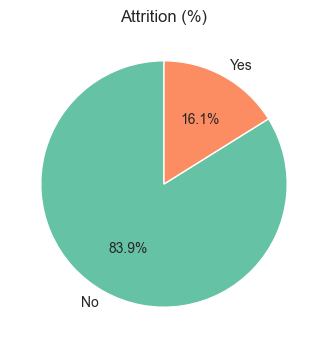

In [51]:
attrition_global = df['attrition'].value_counts(normalize=True) * 100

plt.figure(figsize=(4,4))
plt.pie(
    attrition_global,
    labels=attrition_global.index,
    autopct='%1.1f%%',       
    startangle=90,            
    colors=['#66c2a5', '#fc8d62'],
    wedgeprops={'edgecolor':'white', 'linewidth':1}  
)
plt.title('Attrition (%)')
plt.show()

#### Conclusiones:
Este análisis inicial revela una tasa de rotación del 16.1%, lo que sitúa a la organización en un escenario de alerta moderada-alta. Con este volumen de salidas, se confirma una pérdida constante de capital intelectual y costes operativos de reemplazo que exigen identificar si el problema es sistémico o está focalizado en áreas específicas.

---
### **ANALISIS BIVARIADO EXPLORATORIO**
Tras cuantificar la rotación global, procedemos a realizar un análisis bivariante cruzando el attrition con todas las variables para caracterizar al talento que abandona la compañía. El objetivo en esta fase es puramente descriptivo: buscamos patrones, queremos entender quién se va y bajo qué condiciones se encontraba en el momento de su salida, analizando tanto sus rasgos sociodemográficos como su situación laboral.

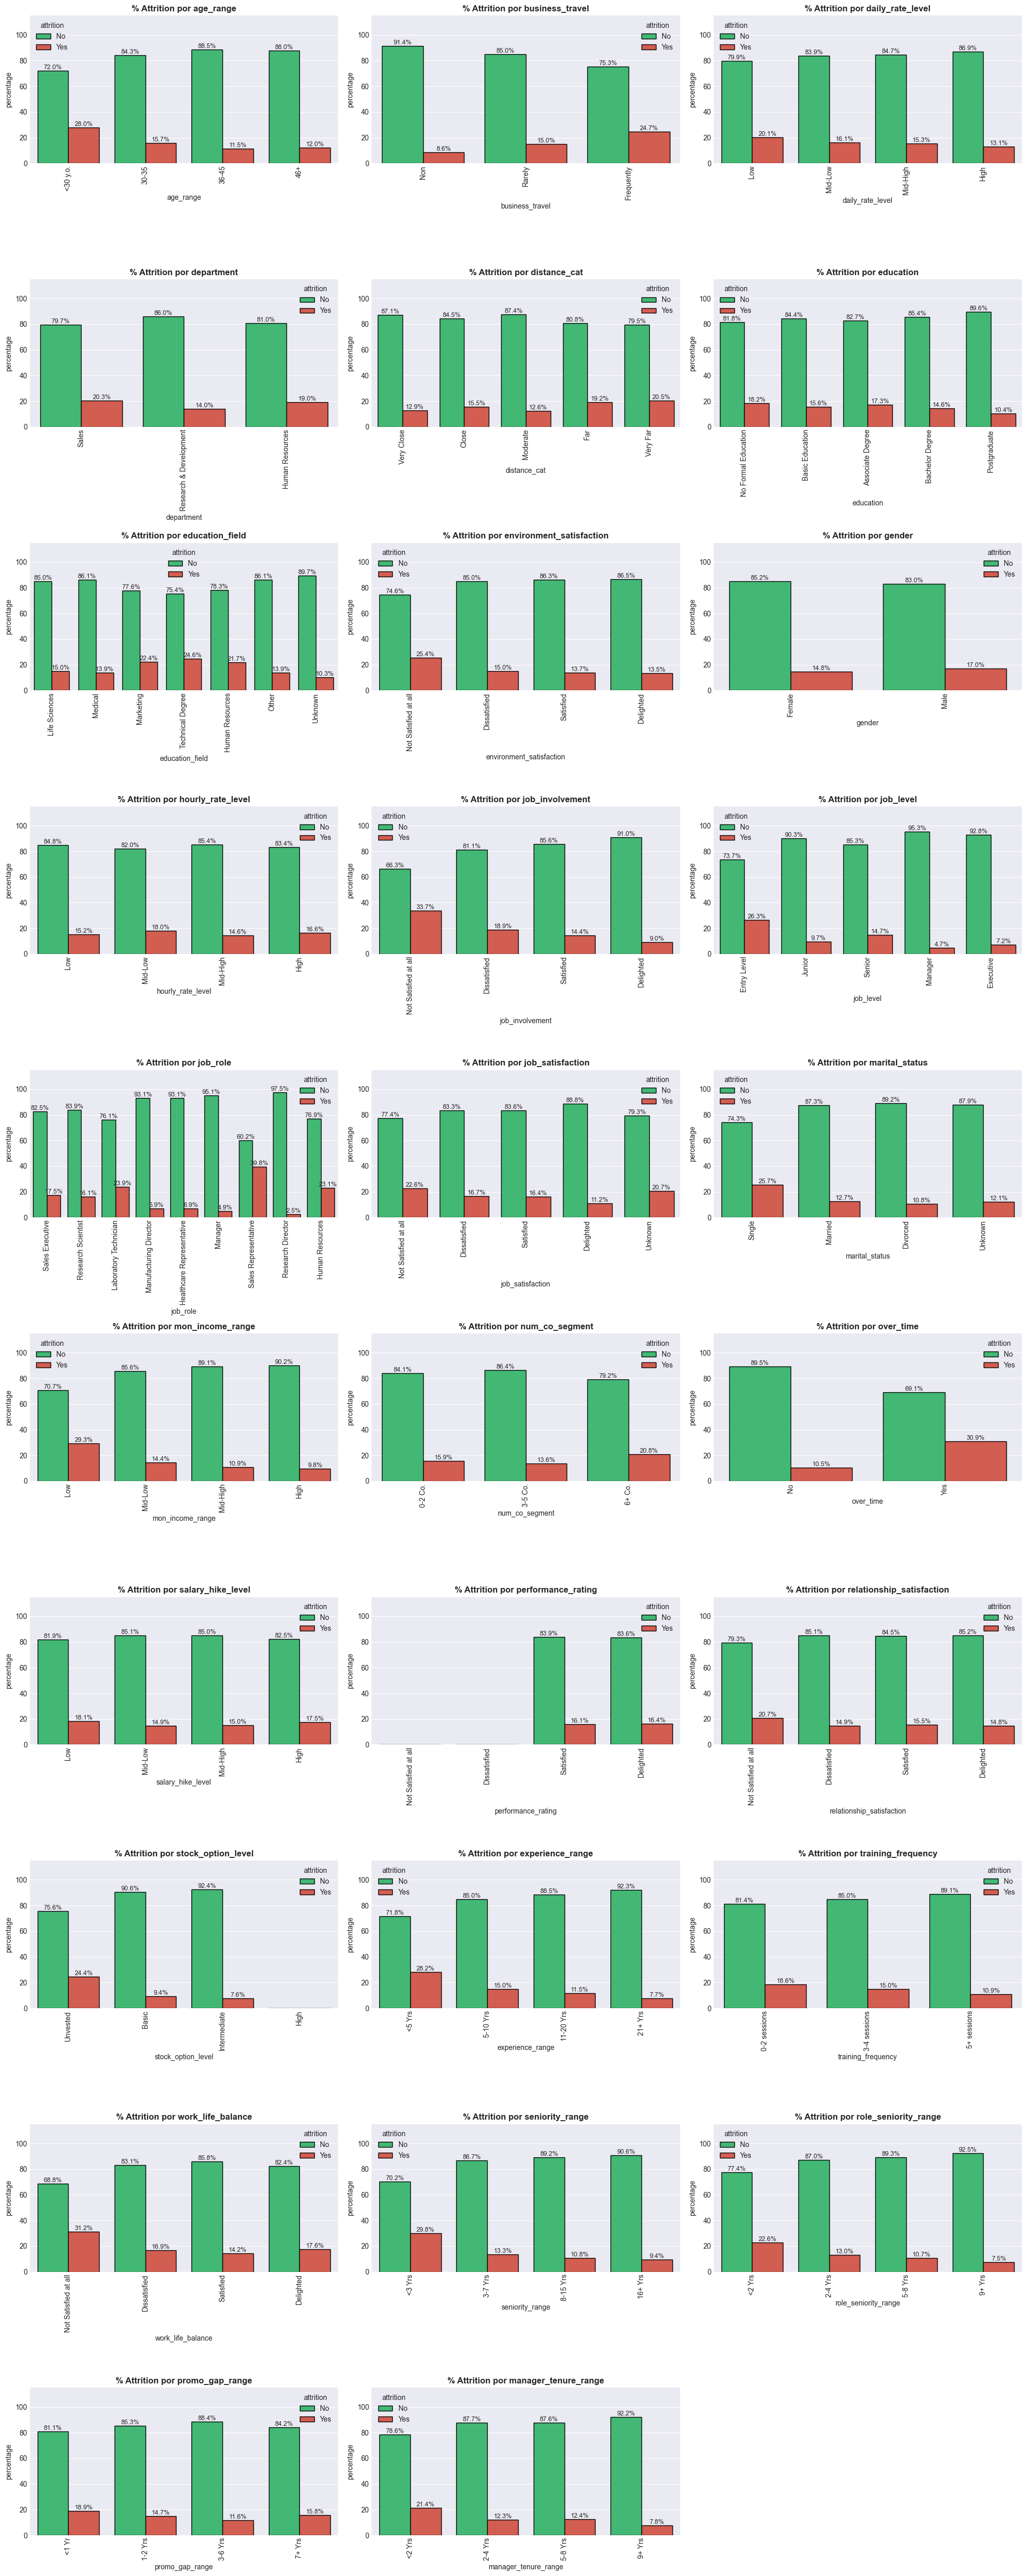

In [52]:
cols_grid = 3
filas_grid = math.ceil(len(columnas_analizar) / cols_grid)

fig, axes = plt.subplots(nrows=filas_grid, ncols=cols_grid, figsize=(20, filas_grid * 5))
axes = axes.flat

for i, col in enumerate(columnas_analizar):
    prop_df = (df.groupby(col)['attrition']
               .value_counts(normalize=True)
               .rename('percentage')
               .reset_index())
    prop_df['percentage'] *= 100 # Convertimos a base 100

    # Graficamos
    sns.barplot(
        data=prop_df, 
        x=col, 
        y='percentage', 
        hue='attrition', 
        ax=axes[i], 
        palette=['#2ecc71', '#e74c3c'],
        edgecolor='black'
    )
    
    axes[i].set_title(f'% Attrition por {col}', fontsize=12, fontweight='bold')
    axes[i].set_ylim(0, 115) # Forzamos el eje Y de 0 a 100% para comparar visualmente
    axes[i].set_xlabel(f'{col}')
    axes[i].tick_params(axis='x', rotation=90)

    # Añadir el número del % sobre las barras para mayor claridad
    for p in axes[i].patches:
        height = p.get_height()
        if height > 0:
            axes[i].annotate(f'{height:.1f}%', 
                             (p.get_x() + p.get_width() / 2., height), 
                             ha='center', va='bottom', fontsize=9)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Conclusiones:
##### Rasgos más frecuentes entre quienes abandonan la empresa:
- **Edad y experiencia**: mayor presencia de empleados jóvenes (<30), con poca experiencia laboral (<5 años) y alta rotación de empresas (+6 empresas diferentes).  
- **Estado civil**: solteros aparecen con mayor frecuencia en la rotación.
- **Distancia a la oficina**: quienes viven lejos o muy lejos tienen mayor rotación.  
- **Rol y nivel**: se observa más rotación en roles comerciales (Sales Representative, Sales Executive), técnicos y becarios.  
- **Condiciones laborales**: empleados con horas extra frecuentes (OverTime) y viajes frecuentes (business travel) se han ido más.  
- **Satisfacción y engagement**: menor job involvement y work-life balance en quienes se van.  
- **Compensación**: salarios bajos y pocas opciones de stock están más presentes entre los que se han ido.  
##### Rasgos más frecuentes entre quienes permanecen:
- **Edad y experiencia**: empleados mayores de 35 años y con experiencia acumulada permanecen más tiempo.  
- **Relación con el manager**: estabilidad con el manager actual se asocia a menor rotación.  
- **Rol y nivel**: roles científicos, gerenciales y técnicos con menor presión muestran menor rotación.  
- **Satisfacción y balance**: mayor job satisfaction y work-life balance se asocian a permanencia.  
- **Compensación**: salarios altos y beneficios (incluyendo stock options) se correlacionan con menor rotación.  
##### En resumen:
- La rotación **refleja quién se ha ido**, no necesariamente qué factores son los más influyentes en el total de la empresa.  
- Los patrones indican que se pierden principalmente **empleados jóvenes en roles de alta presión, con poca experiencia y condiciones laborales exigentes**.  
- Esta información permite **entender por qué se van**, y orientar medidas como mentoring, desarrollo interno, revisión de carga de trabajo y balance laboral, y paquetes de compensación para los grupos críticos.

---

### **IDENTIFICACION DE FACTORES CLAVE: RANKING IMPACTO DE LAS VARIABLES SOBRE EL ATTRITION**
Este análisis busca identificar qué variables presentan mayor asociación con la rotación combinando significancia estadística (Chi²) y fuerza de relación (Cramér’s V).  
El objetivo es priorizar factores relevantes, distinguir asociaciones robustas de ruido estadístico y cuantificar su impacto práctico mediante diferencias en tasas de attrition entre segmentos.

,Variable,Chi2,Cramers_V,Diferencia_%_Max_Min,p_value,Significativo
17,over_time,88.336309,0.245138,20.347766,5.522049e-21,Sí
12,job_role,86.190254,0.242142,37.259036,2.752482e-15,Sí
11,job_level,72.529013,0.222125,21.618194,6.634685e-15,Sí
15,mon_income_range,66.700282,0.213013,19.565217,2.170663e-14,Sí
21,stock_option_level,60.728322,0.209397,16.810769,6.501481e-14,Sí
25,seniority_range,63.781382,0.208300,20.404272,9.140958e-14,Sí
22,experience_range,50.183309,0.185461,20.467253,7.302336e-11,Sí
0,age_range,43.812798,0.172640,16.562648,1.653887e-09,Sí
14,marital_status,42.468912,0.169972,14.877263,3.190479e-09,Sí
26,role_seniority_range,40.593096,0.166176,15.114174,7.976569e-09,Sí


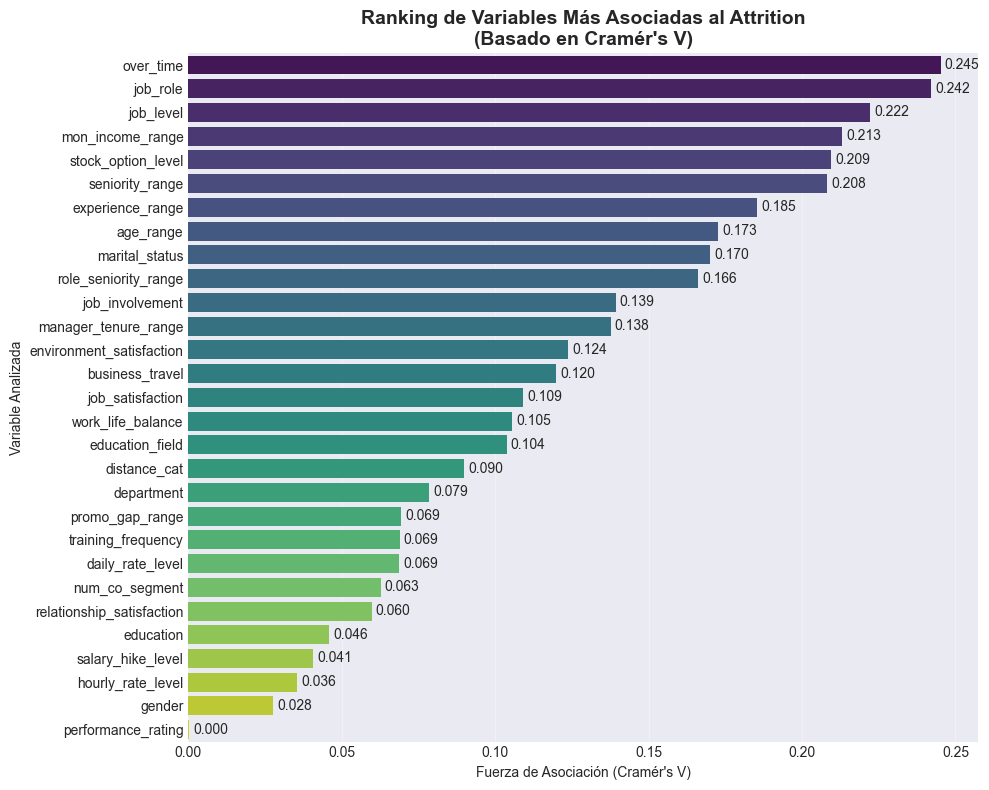

In [54]:
ranking_data = []

for col in columnas_analizar:
    # Tabla de contingencia y chi cuadrado
    contingency = pd.crosstab(df[col], df['attrition'])
    chi2, p_val, _, _ = chi2_contingency(contingency)
    
    # Cramér's V simple
    n = contingency.to_numpy().sum()
    r, k = contingency.shape
    cramers_v = np.sqrt(chi2 / (n * (min(r, k) - 1))) if min(r, k) > 1 else 0
    
    # Diferencia de riesgo
    tabla_pct = pd.crosstab(df[col], df['attrition'], normalize='index') * 100
    if 'Yes' in tabla_pct.columns:
        diferencia_puntos = tabla_pct['Yes'].max() - tabla_pct['Yes'].min()
    else:
        diferencia_puntos = 0

    ranking_data.append({
        'Variable': col,
        'Chi2': chi2,
        'Cramers_V': cramers_v,
        'Diferencia_%_Max_Min': diferencia_puntos,
        'p_value': p_val,
        'Significativo': 'Sí' if p_val < 0.05 else 'No'
    })

df_ranking = pd.DataFrame(ranking_data).sort_values('Cramers_V', ascending=False)
display(df_ranking)

plt.figure(figsize=(10, 8))
ax = sns.barplot(data=df_ranking, x="Cramers_V", y="Variable", palette="viridis")
plt.title("Ranking de Variables Más Asociadas al Attrition\n(Basado en Cramér's V)", fontsize=14, fontweight='bold')
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=3)
plt.xlabel("Fuerza de Asociación (Cramér's V)")
plt.ylabel("Variable Analizada")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

#### Conclusiones

El ranking se ha construido utilizando el coeficiente de Cramér’s V como medida de fuerza de asociación entre cada variable categórica y el attrition. Esta métrica toma valores entre 0 y 1, donde valores cercanos a 0 indican asociación débil y valores más altos indican mayor capacidad discriminativa entre empleados que permanecen y quienes abandonan la empresa. Como guía interpretativa:

- 0 – 0.10 → Asociación débil  
- 0.10 – 0.30 → Asociación moderada  
- 0.30 – 0.50 → Asociación fuerte  
- '> 0.50 → Asociación muy fuerte  

En este análisis, las variables con mayor asociación se sitúan en el rango moderado, lo que es habitual en estudios organizacionales donde la rotación depende de múltiples factores simultáneamente y no de una sola causa dominante.

- La rotación presenta mayor asociación con la realización de horas extra, el rol desempeñado y el nivel jerárquico del puesto, siendo las variables que mejor diferencian entre empleados que permanecen y quienes abandonan la organización.

- También muestran asociación relevante la franja salarial mensual, la antigüedad en la empresa, la experiencia acumulada, el acceso a opciones sobre acciones y el grupo de edad.

- Variables relacionadas con clima laboral y engagement como el nivel de implicación en el trabajo, el equilibrio vida-trabajo, la satisfacción con el entorno y la satisfacción laboral presentan asociación estadísticamente significativa con el attrition.

- Aspectos demográficos básicos (género, nivel educativo, evaluación de desempeño o subida salarial) apenas muestran capacidad discriminativa y no resultan significativos en su mayoría.

- En consecuencia, los resultados sugieren que posibles palancas de actuación para reducir la rotación podrían centrarse en la gestión de la carga de trabajo, el diseño de roles y planes de carrera, la competitividad salarial y las políticas de conciliación y compromiso organizacional.

Cabe destacar que la asociación observada no implica causalidad directa, sino que identifica variables prioritarias para profundizar mediante análisis segmentados o modelos predictivos posteriores.

---
### **ANÁLISIS DE INTERACCIONES: ESTRUCTURA, JERARQUÍA Y ROLES**

¿Dónde se concentra la fuga de talento? El objetivo es identificar si la rotación es un problema generalizado o si está concentrado en determinados departamentos, niveles o puestos específicos. Para ello trabajaremos en una visualización con heatmaps usando una escala de color **YlOrRd** (Amarillo-Naranja-Rojo) donde los tonos más oscuros indican mayor peligro de rotación.


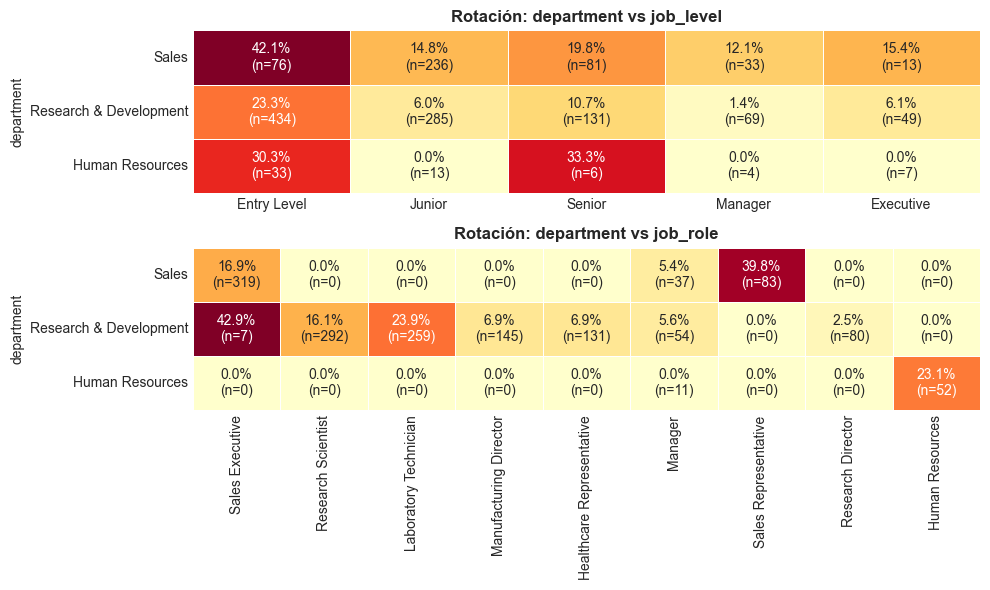

In [55]:
estructurales = ['department']
operativas = ['job_level', 'job_role']

fig, axes = plt.subplots(nrows=len(operativas), ncols=len(estructurales), figsize=(10, 6))
if len(estructurales) == 1:
    axes = axes.reshape(1, -1)

for i, var_y in enumerate(estructurales):
    for j, var_x in enumerate(operativas):
        temp_df = df.groupby([var_y, var_x])['attrition'].value_counts(normalize=True).mul(100).reset_index(name='porcentaje')
        temp_df = temp_df[temp_df['attrition'] == 'Yes']
        heatmap_data = temp_df.pivot(index=var_y, columns=var_x, values='porcentaje')

        # Conteos reales (n)
        counts = df.groupby([var_y, var_x]).size().reset_index(name='n')
        count_matrix = counts.pivot(index=var_y, columns=var_x, values='n')

        # Alinear matrices
        heatmap_data = heatmap_data.fillna(0)
        count_matrix = count_matrix.reindex_like(heatmap_data).fillna(0)

        # Crear etiquetas combinadas
        labels = heatmap_data.copy().astype(str)
        for r in heatmap_data.index:
            for c in heatmap_data.columns:
                pct = heatmap_data.loc[r, c]
                n = int(count_matrix.loc[r, c])
                labels.loc[r, c] = f"{pct:.1f}%\n(n={n})"

        sns.heatmap(heatmap_data, annot=labels, fmt="", cmap='YlOrRd', ax=axes[i, j], cbar=False, linewidths=0.5)
        axes[i, j].set_title(f'Rotación: {var_y} vs {var_x}', fontweight='bold')
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel(var_y)

plt.tight_layout()
plt.show()


#### Conclusiones

El análisis conjunto de departamentos, niveles y roles permite identificar varios focos relevantes de rotación:

1. **Vulnerabilidad en Ventas:**  
El departamento de Sales muestra uno de los principales focos de rotación, especialmente en niveles iniciales y roles comerciales específicos, lo que sugiere mayor exposición a abandono en funciones orientadas a objetivos y presión operativa.

2. **Mayor incidencia en niveles de entrada:**  
La rotación se concentra en posiciones Entry y Junior en múltiples departamentos. Este patrón podría estar asociado a procesos de adaptación inicial, expectativas laborales o incentivos de retención en etapas tempranas de carrera.

3. **Rotación en perfiles experimentados (heterogénea):**  
Se observan casos de rotación en niveles senior, aunque sin un patrón uniforme entre departamentos. Esto sugiere la necesidad de análisis adicional antes de atribuir causas estructurales.

**Desequilibrio estructural:**  
Los resultados sugieren una distribución desigual de la rotación entre niveles jerárquicos, con mayor incidencia en niveles iniciales y focos específicos en determinados roles especializados. Esto apunta a la conveniencia de revisar estrategias de retención diferenciadas por segmento organizativo.

---
### **IDENTIFICACIÓN DE PUNTOS CRÍTICOS DE ATTRITION**

El objetivo es identificar combinaciones específicas de factores que generan las tasas más altas de rotación de empleados. Para ello seguimos el siguiente enfoque: cruzamos variables **ESTRUCTURALES** (características del puesto difíciles de modificar) con variables **OPERATIVAS** (condiciones gestionables por la empresa) para localizar "puntos calientes" de attrition mediante visualización en matrices de calor.
Para nosotros, combinaciones con attrition > 40% serán consideradas como umbral crítico.


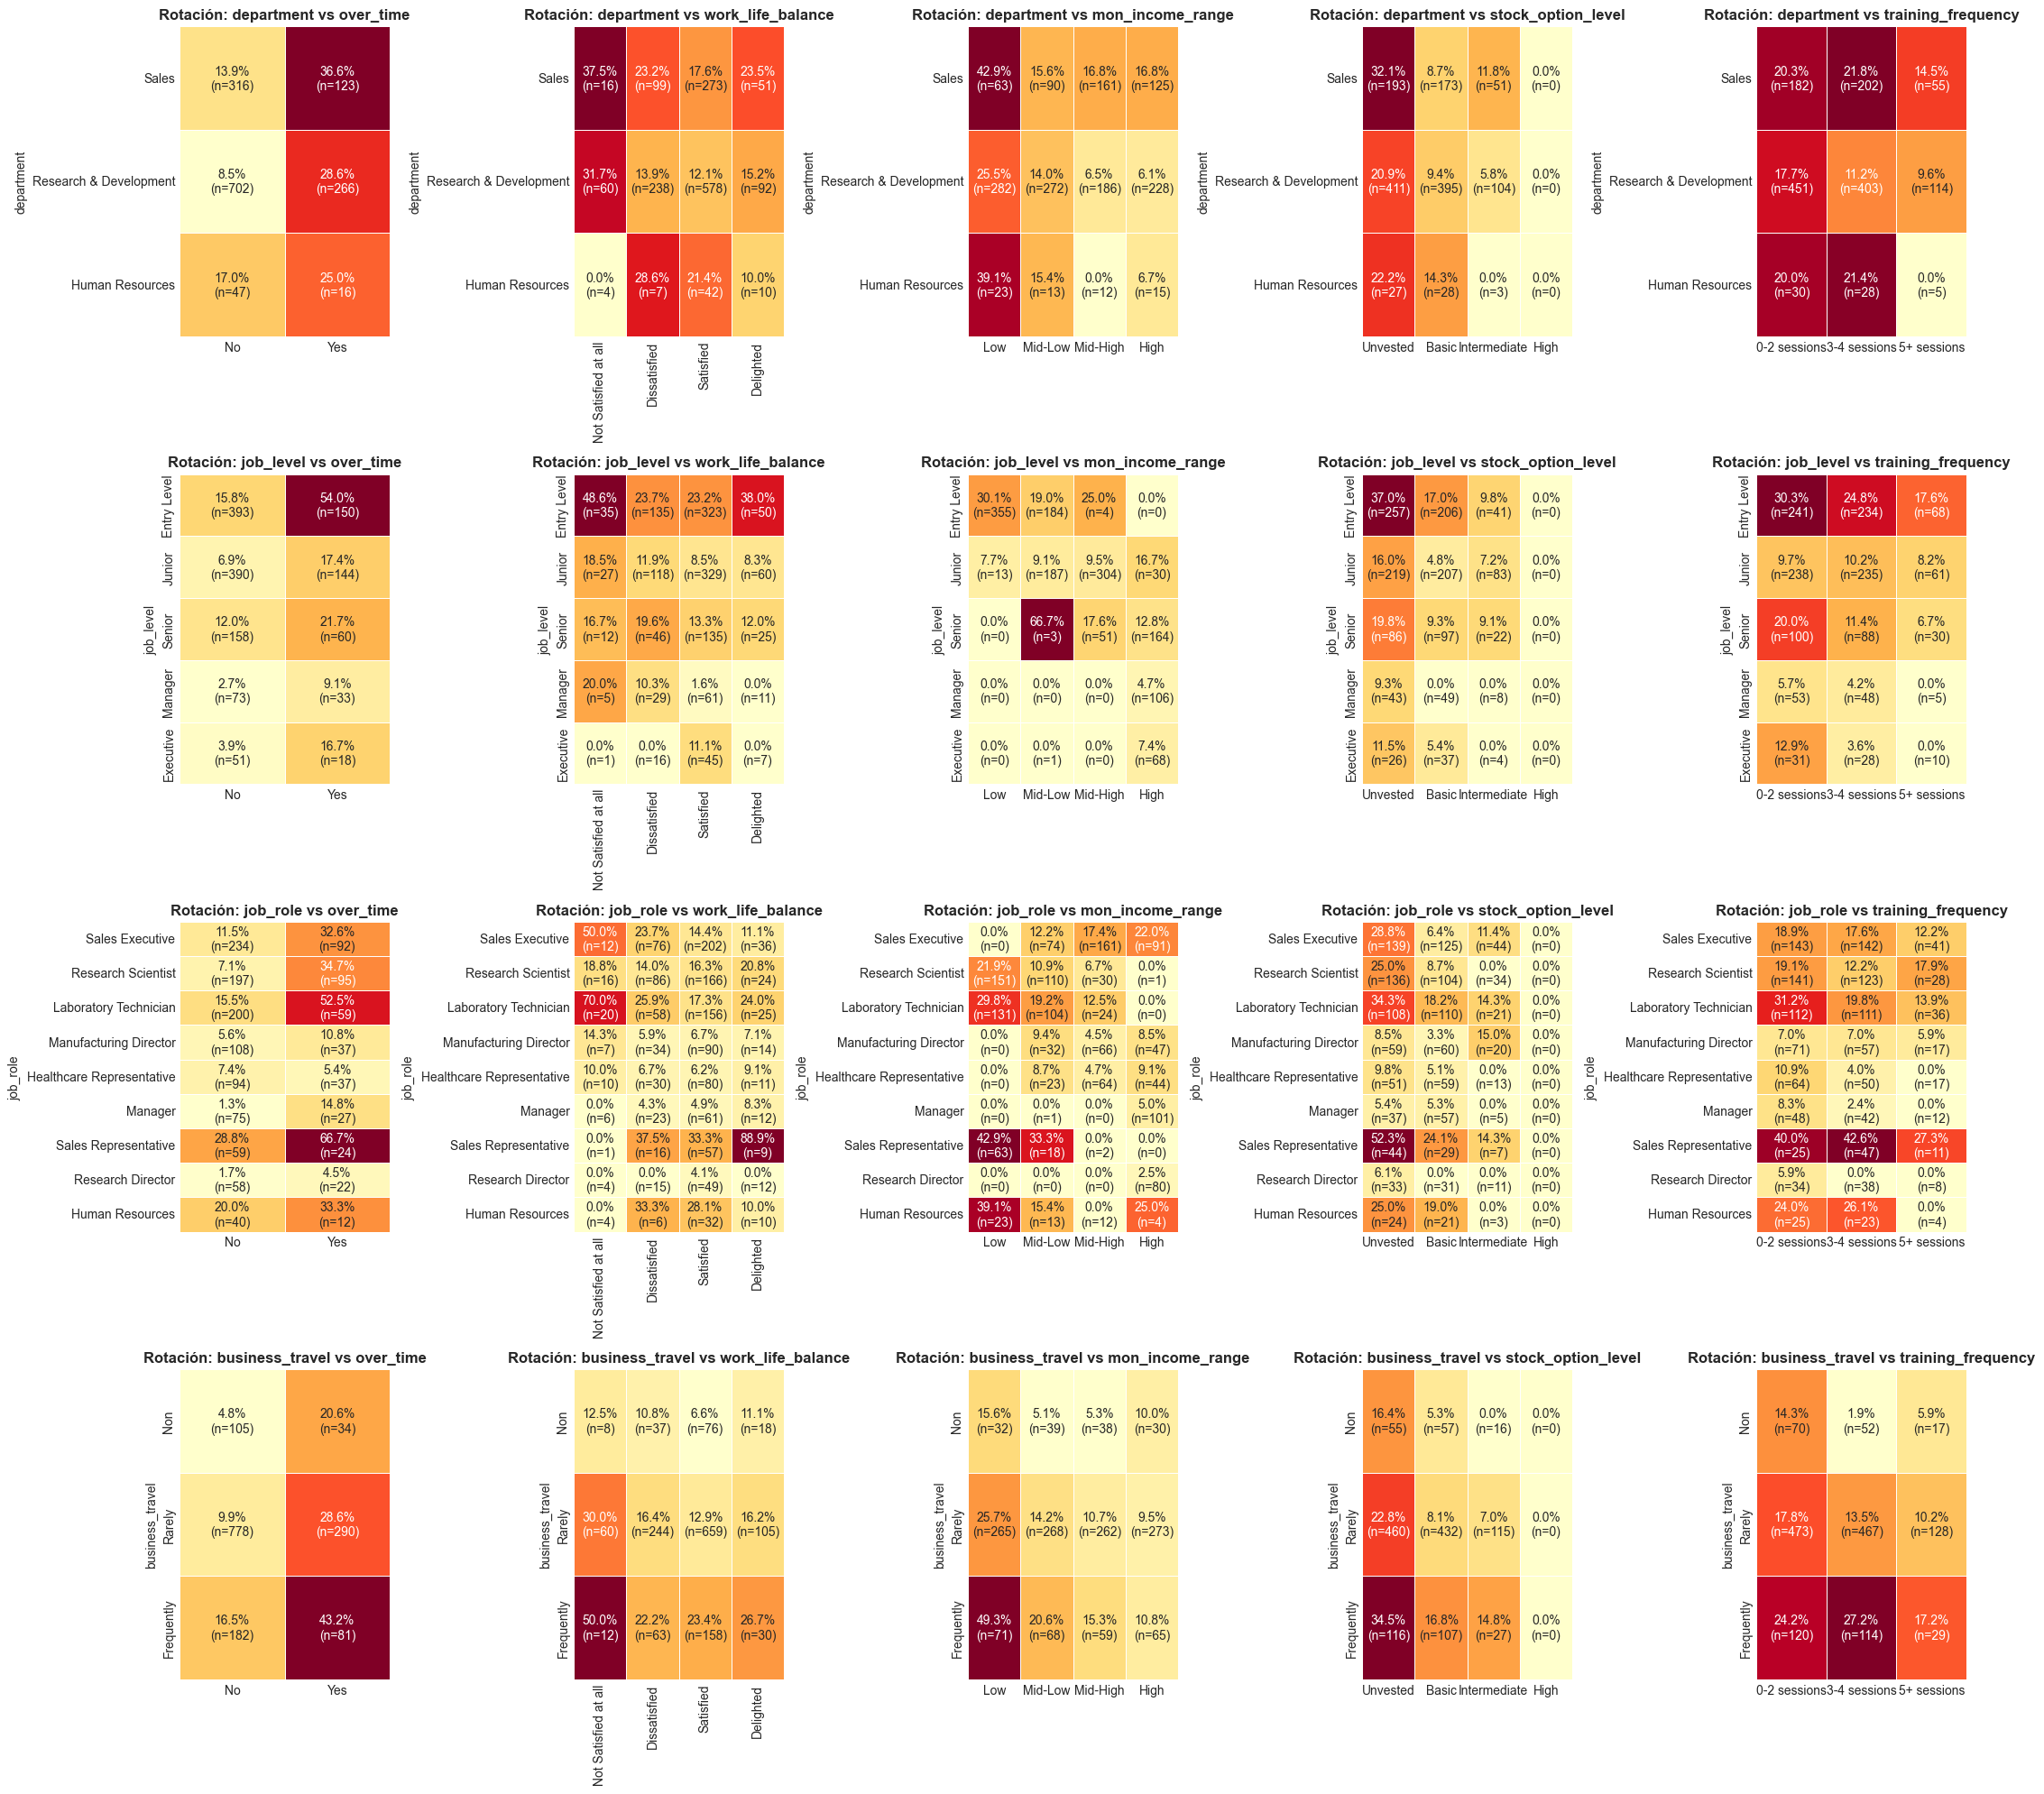

In [56]:
estructurales = ['department', 'job_level', 'job_role', 'business_travel']
operativas = ['over_time', 'work_life_balance','mon_income_range', 'stock_option_level', 'training_frequency']

fig, axes = plt.subplots(nrows=len(estructurales), ncols=len(operativas), figsize=(22, 20))

for i, var_y in enumerate(estructurales):
    for j, var_x in enumerate(operativas):
        
        # -------- % Attrition --------
        temp_df = (df.groupby([var_y, var_x])['attrition'].value_counts(normalize=True).mul(100).reset_index(name='pct'))
        
        temp_df = temp_df[temp_df['attrition'] == 'Yes']
        heatmap_pct = temp_df.pivot(index=var_y, columns=var_x, values='pct')

        # -------- Conteos n --------
        counts = df.groupby([var_y, var_x]).size().reset_index(name='n')
        heatmap_n = counts.pivot(index=var_y, columns=var_x, values='n')

        # -------- Alinear matrices --------
        heatmap_pct = heatmap_pct.fillna(0)
        heatmap_n = heatmap_n.reindex_like(heatmap_pct).fillna(0)

        # -------- Crear etiquetas --------
        labels = heatmap_pct.copy().astype(str)
        for r in heatmap_pct.index:
            for c in heatmap_pct.columns:
                pct = heatmap_pct.loc[r, c]
                n = int(heatmap_n.loc[r, c])
                labels.loc[r, c] = f"{pct:.1f}%\n(n={n})"
        sns.heatmap(heatmap_pct, annot=labels, fmt="", cmap='YlOrRd', ax=axes[i, j], cbar=False, linewidths=0.5)
        axes[i, j].set_title(f'Rotación: {var_y} vs {var_x}', fontweight='bold')
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel(var_y)
plt.tight_layout()
plt.show()



#### Conclusiones

El análisis de interacciones entre variables estructurales y operativas permite identificar segmentos con mayor asociación a la rotación. Estas observaciones deben interpretarse como relaciones exploratorias —no causales— y considerando que algunas combinaciones presentan tamaños muestrales reducidos.

* **Elevada rotación en determinados subsegmentos de Laboratory Technicians:**  
Se observan tasas altas de rotación en combinaciones asociadas a bajo equilibrio vida-trabajo y realización de horas extra. No obstante, algunas celdas presentan muestras pequeñas, por lo que el resultado debe interpretarse con cautela.  
    * **Línea de acción sugerida:** Analizar condiciones laborales y carga operativa en este rol para validar si existe desgaste organizacional.

* **Vulnerabilidad consistente en Sales Representatives:**  
Este rol muestra asociación con múltiples factores de riesgo (horas extra, niveles salariales bajos y menor acceso a beneficios), con tamaños muestrales suficientemente amplios y patrones consistentes en distintos cruces.  
    * **Línea de acción sugerida:** Evaluar estrategias integrales de retención que incluyan compensación, incentivos y rediseño de carga de trabajo.

* **Rotación en perfiles senior (patrón heterogéneo):**  
Se detectan episodios puntuales de rotación elevada en determinados segmentos senior, aunque sin evidencia consistente de patrón estructural generalizado.  
    * **Línea de acción sugerida:** Profundizar en análisis segmentado antes de plantear intervenciones salariales o estratégicas.

* **Asociación entre horas extra y rotación en niveles iniciales:**  
Se observa una mayor incidencia de abandono en empleados junior que realizan horas extra, respaldada por tamaños muestrales relevantes y coherente con análisis previos.  
    * **Línea de acción sugerida:** Revisar políticas de carga laboral y acompañamiento en etapas tempranas de carrera.

* **Mayor rotación en empleados con viajes frecuentes:**  
El análisis sugiere una mayor asociación entre movilidad laboral intensiva y rotación, aunque el patrón no es uniforme en todos los segmentos.  
    * **Línea de acción sugerida:** Evaluar políticas de compensación o flexibilidad para empleados con alta exposición a desplazamientos.

---
### **TOP10 COMBINACIONES DE MÁS RIESGO**
El objetivo es encontrar los segmentos más críticos para identificar perfiles organizativos donde la rotación es más pronunciada y orientar posibles acciones de retención

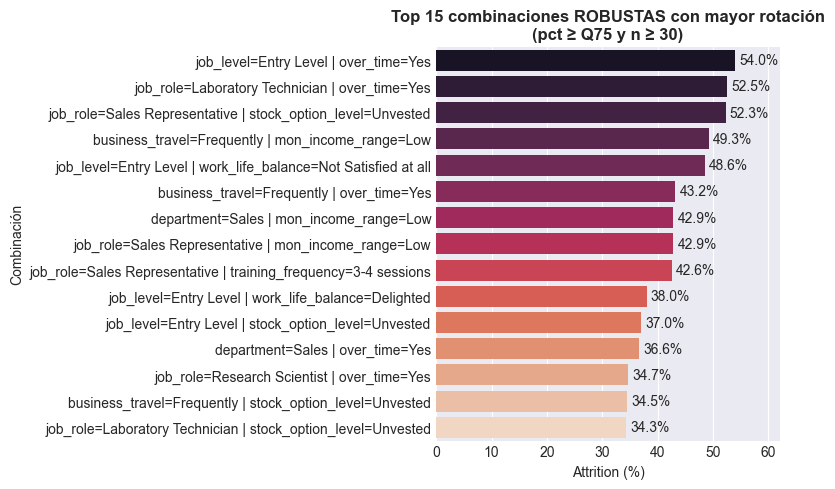

In [57]:
combos_df = pd.concat([
    df.groupby([y, x]).size().rename("n").to_frame()
      .join(
          df.groupby([y, x])["attrition"]
            .value_counts(normalize=True)
            .mul(100)
            .rename("pct")
            .reset_index(level=2)
            .query("attrition=='Yes'")
            .drop(columns="attrition")
      )
      .reset_index()
      .assign(struct_var=y, op_var=x)
    for y in estructurales
    for x in operativas
], ignore_index=True).fillna({"pct": 0})

min_n = 30
threshold = combos_df["pct"].quantile(0.75)
robust = combos_df[(combos_df["pct"] >= threshold) & (combos_df["n"] >= min_n)].copy()
top = robust.sort_values(["pct", "n"], ascending=False).head(15).copy()
top["combo"] = top.apply(lambda r: f"{r['struct_var']}={r[r['struct_var']]} | {r['op_var']}={r[r['op_var']]}", axis=1)

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=top, x="pct", y="combo", palette="rocket")
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", padding=3)
plt.title(f"Top 15 combinaciones ROBUSTAS con mayor rotación\n(pct ≥ Q75 y n ≥ {min_n})", fontweight="bold")
plt.xlabel("Attrition (%)")
plt.ylabel("Combinación")
plt.xlim(0, top["pct"].max() * 1.15)
plt.tight_layout()
plt.show()

#### Conclusiones:

El análisis revela que la rotación más elevada se concentra en perfiles de entrada y en roles comerciales y técnicos expuestos a condiciones laborales exigentes. La realización de horas extra aparece de forma recurrente como uno de los factores más asociados a abandono, especialmente en empleados junior, técnicos de laboratorio y científicos, lo que sugiere una posible sobrecarga operativa en estos segmentos.

Asimismo, variables relacionadas con compensación y beneficios —como niveles salariales bajos o ausencia de stock options— se repiten entre los segmentos con mayor attrition, particularmente en Sales Representatives y empleados con viajes frecuentes, apuntando a una posible desalineación entre esfuerzo requerido y recompensa percibida.

Finalmente, el análisis muestra que la rotación no responde a un único factor aislado, sino a combinaciones de condiciones organizativas (carga de trabajo, movilidad, incentivos y satisfacción personal). Esto refuerza la necesidad de estrategias de retención segmentadas que aborden simultáneamente compensación, balance laboral y diseño del puesto en los colectivos más expuestos.


---
### **DINÁMICA DE PROGRESION SALARIAL**
Analizar la relación entre experiencia temporal y progresión salarial, comparando empleados que permanecen y quienes abandonan, para detectar posibles patrones retributivos asociados a la rotación.

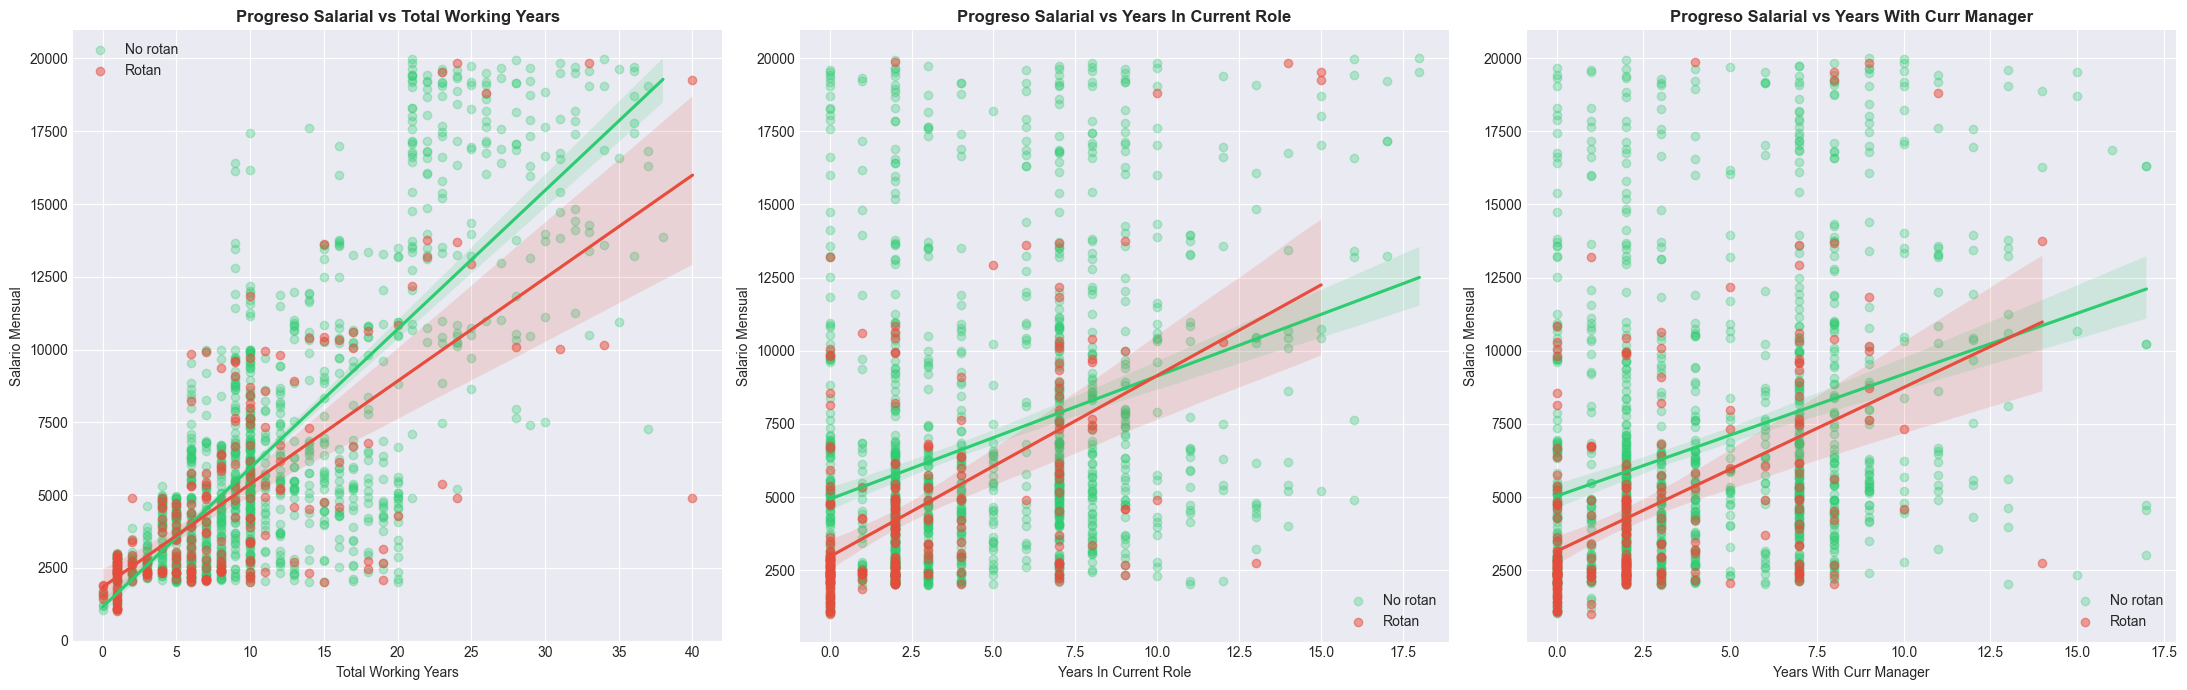

In [58]:
variables_tiempo = ['total_working_years', 'years_in_current_role', 'years_with_curr_manager']

fig, axes = plt.subplots(1, 3, figsize=(22, 7))

for i, var in enumerate(variables_tiempo):
    # Regresión para los que se QUEDAN (Azul)
    sns.regplot(data=df[df['attrition'] == 'No'], x=var, y='monthly_income', 
                ax=axes[i], scatter_kws={'alpha':0.3}, label='No rotan', color='#2ecc71')
    
    # Regresión para los que se VAN (Rojo)
    sns.regplot(data=df[df['attrition'] == 'Yes'], x=var, y='monthly_income', 
                ax=axes[i], scatter_kws={'alpha':0.5}, label='Rotan', color='#e74c3c')
    
    axes[i].set_title(f'Progreso Salarial vs {var.replace("_", " ").title()}', fontweight='bold')
    axes[i].set_xlabel(var.replace("_", " ").title())
    axes[i].set_ylabel('Salario Mensual')
    axes[i].legend()

plt.tight_layout()
plt.show()

#### Conclusiones:
El salario sube con la experiencia en todos los casos, pero quienes se quedan progresan algo más rápido que quienes se van, sobre todo al mirar los años totales trabajados y los años en el rol actual.

---
### **ANÁLISIS DE BRECHA SALARIAL Y EQUIDAD INTERNA**
El objetivo de este análisis es, mediante el cálculo de medianas salariales y la aplicación de tests ANOVA, determinar si existe una diferencia sistemática entre lo que percibe un empleado que permanece frente a uno que se va, bajo las mismas condiciones de antigüedad y rol.

,variable,grupo,n_No,n_Yes,med_No,med_Yes,gap,%gap,p_value
8,promo_gap_range,<1 Yr,471,110,4682.0,2688.0,1994.0,42.588637,7.160272e-11
4,role_seniority_range,<2 Yrs,521,152,4157.0,2617.5,1539.5,37.033919,1.149167e-10
12,manager_tenure_range,<2 Yrs,537,146,4240.0,2688.0,1552.0,36.603774,1.467009e-10
9,promo_gap_range,1-2 Yrs,440,76,4735.5,3081.0,1654.5,34.938232,2.175767e-05
0,experience_range,<5 Yrs,219,86,2819.0,2455.5,363.5,12.894643,4.938452e-04
1,experience_range,5-10 Yrs,516,91,4907.0,4084.0,823.0,16.771958,1.766575e-02
11,promo_gap_range,7+ Yrs,154,29,8904.0,5828.0,3076.0,34.546271,3.174331e-02
3,experience_range,21+ Yrs,191,16,16799.0,13065.0,3734.0,22.227514,8.031940e-02
14,manager_tenure_range,5-8 Yrs,352,50,5977.0,5715.0,262.0,4.383470,1.213446e-01
13,manager_tenure_range,2-4 Yrs,214,30,4840.0,4052.0,788.0,16.280992,1.853594e-01


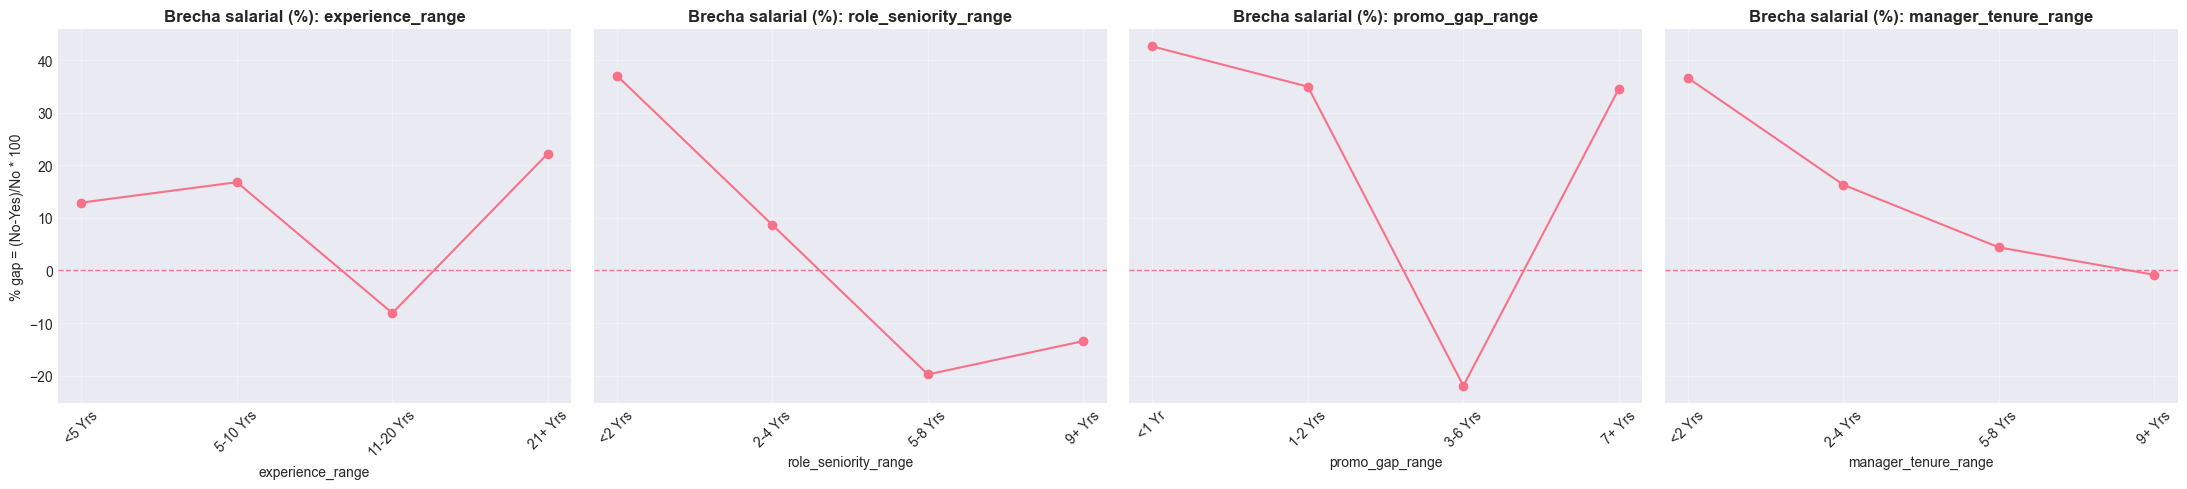

In [61]:
agrupaciones = ['experience_range', 'role_seniority_range', 'promo_gap_range', 'manager_tenure_range']
MIN_N = 15  # mínimo de casos por grupo (No y Yes) para hacer el test Manny

res = []

for col in agrupaciones:
    for g, sub in df.dropna(subset=[col, "monthly_income", "attrition"]).groupby(col, observed=True):
        no = sub.loc[sub["attrition"] == "No", "monthly_income"]
        yes = sub.loc[sub["attrition"] == "Yes", "monthly_income"]

        n_no, n_yes = len(no), len(yes)
        med_no, med_yes = no.median(), yes.median()
        gap = med_no - med_yes
        pct_gap = (gap / med_no * 100) if med_no else np.nan

        p = np.nan
        if n_no >= MIN_N and n_yes >= MIN_N:
            _, p = mannwhitneyu(no, yes, alternative="two-sided")

        res.append([col, g, n_no, n_yes, med_no, med_yes, gap, pct_gap, p])

resultado = pd.DataFrame(
    res,
    columns=["variable","grupo","n_No","n_Yes","med_No","med_Yes","gap","%gap","p_value"]
).sort_values(["p_value","%gap"], ascending=[True, False])

display(resultado)

fig, axes = plt.subplots(1, 4, figsize=(22, 5), sharey=True)

for i, col in enumerate(agrupaciones):
    tmp = resultado[resultado["variable"] == col].copy()
    tmp["grupo"] = pd.Categorical(tmp["grupo"], categories=ordenes_logicos[col], ordered=True)
    tmp = tmp.sort_values("grupo")
    axes[i].plot(tmp["grupo"], tmp["%gap"], marker="o")
    axes[i].axhline(0, linestyle="--", linewidth=1)
    axes[i].set_title(f"Brecha salarial (%): {col}", fontweight="bold")
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)
    if i == 0:
        axes[i].set_ylabel("% gap = (No-Yes)/No * 100")

plt.tight_layout()
plt.show()


#### Conclusiones

Valor positivo: Los que se quedan ganan más - Valor negativo: Los que rotan ganan más.

Las visualizaciones muestran un patrón consistente en el que la diferencia salarial entre empleados que permanecen y quienes abandonan la organización se concentra principalmente en las fases iniciales de la trayectoria profesional. En los tramos de menor experiencia, antigüedad en el rol o tiempo con el responsable directo, se observa una brecha positiva elevada, indicando que los empleados que permanecen presentan salarios medianos significativamente superiores.

A medida que aumenta la trayectoria profesional, esta brecha se reduce progresivamente y pierde significancia estadística, en conjunto, los resultados sugieren que la compensación económica actúa como un mecanismo de retención especialmente relevante en las primeras etapas del ciclo laboral dentro de la organización, mientras que en etapas avanzadas la decisión de abandono parece estar influida por otros factores organizativos o motivacionales.

---
### **ANÁLISIS DE MOVILIDAD INTERNA: ¿PLAN DE CARRERA O ESTANCAMIENTO?**
Tras detectar que las promociones recientes presentan brechas salariales, este análisis busca entender la dinámica del progreso profesional. El objetivo es visualizar cuánto tiempo permanecen los empleados en cada nivel jerárquico (job_level) para determinar si la estructura permite un crecimiento ágil o si genera estancamiento.

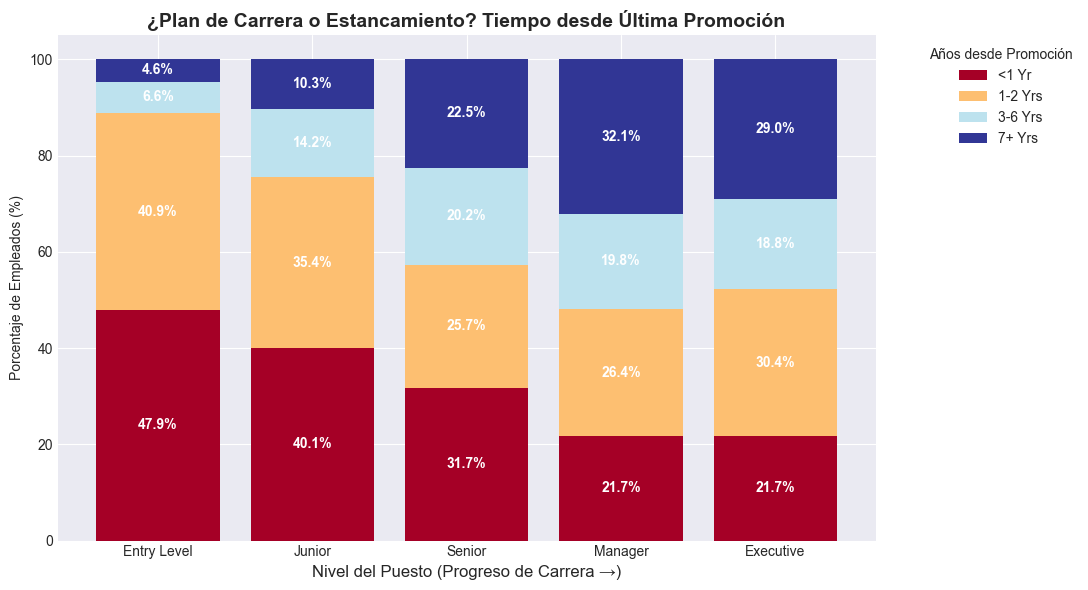

In [60]:
df_pct = pd.crosstab(df['job_level'], df['promo_gap_range'], normalize='index').sort_index() * 100
ax = df_pct.plot(kind='bar', stacked=True, figsize=(11, 6), colormap='RdYlBu', width=0.8)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 2:
        ax.text(x + width/2, y + height/2, f'{height:.1f}%', 
                ha='center', va='center', color='white', fontweight='bold')

plt.title('¿Plan de Carrera o Estancamiento? Tiempo desde Última Promoción', fontweight='bold', fontsize=14)
plt.xlabel('Nivel del Puesto (Progreso de Carrera →)', fontsize=12)
plt.ylabel('Porcentaje de Empleados (%)')
plt.legend(title='Años desde Promoción', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Conclusiones:
Existe un claro bloqueo de carrera en los niveles intermedios y altos. La falta de movimiento en las posiciones de Manager y Executive impide la circulación de talento hacia arriba, creando una estructura donde el crecimiento se detiene bruscamente al alcanzar la gestión media. Atención con los niveles becario y junior: hay un % considerable de empleados que parecen haber quedado "atrapados" en el rol por más de 7 años, una cifra inusual para un nivel de desarrollo inicial.